In [1]:
## Ambient Fisher Gnomonic Interpolant

by Kyle Cranmer, Jan 12, 2014, BSD license

based on notes and discussion with Jeff Streets at UCI.

<img src="files/gnome-fishing.jpg" alt="Gnome Fisher" width="20%"><img src="files/gnome-mesh.jpg" alt="Gnome Mesh" width="20%">
<!--
![Gnome Fisher](files/gnome-fishing.jpg)![gnome mesh](files/gnome-mesh.jpg)
-->

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import numpy.linalg as linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import scipy.optimize
from math import sqrt
from scipy.spatial import Delaunay

## Create pairs of (parameter, distribution)

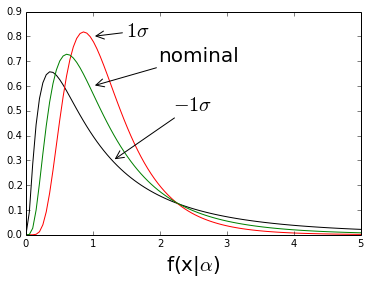

In [4]:
#parameter points
alphas = np.array([[0,0],[0.1,-0.5],[0,-0.3]])

# dim = 1+#dim parameters = dim of embedding
dim = 3 
# for starters, define a parametrized family of functions explicitly and draw from it
f = lambda alpha: lambda x : np.exp(-(np.log(x)-alpha[0])**2 / (2*(alpha[1]+1)**2))/(np.sqrt(2*np.pi)*x*(alpha[1]+1))
dists = []
for alpha in alphas:
    dists.append( f(alpha) )
    
xarray = np.linspace(0.0000001,5,100)
plt.plot(xarray,dists[0](xarray),c='black')
plt.plot(xarray,dists[1](xarray),c='r')
plt.plot(xarray,dists[2](xarray),c='g')
plt.annotate('$1 \sigma$', xy=(1, 0.8), xytext=(1.5,0.8), size=20,
                         arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate('nominal', xy=(1, 0.6), xytext=(2,0.7), size=20,
                         arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate('$-1 \sigma$', xy=(1.3, 0.3), xytext=(2.2,0.5), size=20,
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.xlabel(r'f(x|$\alpha$)', fontsize = 20)
plt.show()

## Calculate pair-wise chord distances, embed on n-sphere, & rotate first to south pole

It's going to be easier to work in the space of the sqrt of distributions, so let's define a simple transformation q 

In [5]:
q = lambda h: (lambda x: np.sqrt(h(x)))

In [6]:
def inner_product(q1,q2, xmin=0.000001, xmax=7):
    # this is a simple numeric integration
    num = 10000.
    xarray = np.linspace(xmin,xmax,num)
    return np.sum(q1(xarray) * q2(xarray))*(xmax-xmin)/num

In [7]:
(inner_product(q(dists[0]),q(dists[0])), inner_product(q(dists[1]),q(dists[1])),inner_product(q(dists[2]),q(dists[2])))

(0.97407281989338412, 0.99978872752528403, 0.99718185046552932)

## Create pairs of (parameter simplex, Gnomonic simplex)

In [8]:
def getChordDistance(q1,q2):
    return 2.*np.sin( np.arccos( inner_product(q1, q2) ) /2. )

In [9]:
tempSim=[]
for f1 in dists:
    temp = []
    for f2 in dists:
        temp.append(getChordDistance(q(f1),q(f2)))
    tempSim.append(temp)
chordDistMatrix=np.array(tempSim)
chordDistMatrix #diagonals should be close to 0

array([[ 0.22771552,  0.46661701,  0.27830065],
       [ 0.46661701,  0.0205559 ,  0.25022651],
       [ 0.27830065,  0.25022651,  0.07507529]])

In [10]:
## Embeding functions onto n-sphere
n=dim-1
embeded=np.zeros(shape=(dim,dim))
embeded[0]=[0,0,-1]
a=np.array([[-1], [2,3]], dtype=object)

for k in range(1,dim):
    y=np.empty([k,k])
    z=np.zeros(k)
    for j in range(0,k):
        z[j]=1-(chordDistMatrix[j][k]**2)*0.5
        y[j]=np.delete(embeded[j],np.arange(n+1-k))
    x = np.linalg.solve(y,z)
    x_0k=-sqrt(1-np.sum(x**2)) #negative sign to keep it totally in southern hemisphere
    a=np.append(x_0k,x)
    embeded[k]=np.append(np.zeros(n-k),a)
embeded

array([[ 0.        ,  0.        , -1.        ],
       [ 0.        , -0.45373967, -0.89113428],
       [-0.12226166, -0.2469892 , -0.96127437]])

In [11]:
pointsOnSphere = embeded.copy()

In [12]:
gnomonicProjection = pointsOnSphere.copy()
for i, point in enumerate(pointsOnSphere):
    gnomonicProjection[i] = -1.*point/point[2]
    print point[2], point 

-1.0 [ 0.  0. -1.]
-0.891134282569 [ 0.         -0.45373967 -0.89113428]
-0.961274373429 [-0.12226166 -0.2469892  -0.96127437]


In [13]:
nSamples = 15 #samples along ray for visualization
rays = np.zeros((3*nSamples,dim))
for i, point in enumerate(gnomonicProjection):
    for j, c in enumerate(np.linspace(0,1,nSamples)):
        rays[i*nSamples+j] = c * point

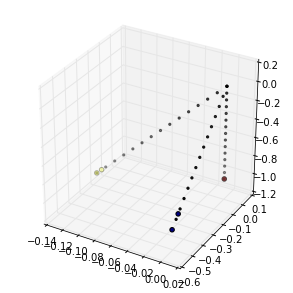

In [14]:
fig = plt.figure(figsize=(5,5))
subpl = fig.add_subplot(111,projection='3d')
subpl.scatter(rays[:, 0], rays[:, 1], rays[:, 2],marker='.',c=pointsOnSphere[:,0]*0+.01)
subpl.scatter(pointsOnSphere[:, 0], pointsOnSphere[:, 1],pointsOnSphere[:, 2],
              marker='o',c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
subpl.scatter(gnomonicProjection[:, 0], gnomonicProjection[:, 1], gnomonicProjection[:, 2],
              c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
plt.show()

In [15]:
alphaSimplex = Delaunay(alphas)
gnomonicSimplex = Delaunay(gnomonicProjection[:3,:2])

In [16]:
normedVertices = gnomonicProjection[:3,:2].copy()
normedVertices[1] /= linalg.norm(normedVertices[1])
normedVertices[2] /= linalg.norm(normedVertices[2])
normedSimplex = Delaunay(normedVertices)


In [17]:
inner_product(q(dists[0]),q(dists[1])),inner_product(q(dists[0]),q(dists[2])),inner_product(q(dists[1]),q(dists[2]))

(0.89113428256913918, 0.96127437342880262, 0.96869334773531757)

In [18]:
pointsOnSphere[0].dot(pointsOnSphere[1]),pointsOnSphere[0].dot(pointsOnSphere[2]),pointsOnSphere[1].dot(pointsOnSphere[2])

(0.89113428256913918, 0.96127437342880262, 0.96869334773531757)

## Create Interpolant

In [23]:
#alpha1 = np.array([0.9,0.0]) #for testing
#alpha2 = np.array([0.0,.9]) #for testing
#alpha = alpha2 #switch for testing
alpha = np.array([0.05,-0.25])
baryCoords = alphaSimplex.transform[0,:dim-1,:].dot(alpha)
gnomonicTarget = linalg.inv(gnomonicSimplex.transform[0,:dim-1,:]).dot(baryCoords)
normedBaryCoords = normedSimplex.transform[0,:dim-1,:].dot(gnomonicTarget)
t = np.arctan(linalg.norm(gnomonicTarget))
t 
normedBaryCoords #linalg.norm(gnomonicTarget), linalg.norm(gnomonicProjection[1,:2]), linalg.norm(gnomonicProjection[2,:2])
gnomonicProjection[1:], gnomonicTarget

(array([[ 0.        , -0.50917093, -1.        ],
        [-0.12718706, -0.25693934, -1.        ]]),
 array([ 0.06359353,  0.12846967]))

In [129]:
dot01 = inner_product(q(dists[0]),q(dists[1]))
dot02 = inner_product(q(dists[0]),q(dists[2]))
t1 = lambda x: q(dists[1])(x) - dot01*q(dists[0])(x)
t2 = lambda x: q(dists[2])(x) - dot02*q(dists[0])(x)
norm1 = inner_product(t1,t1)
norm2 = inner_product(t2,t2)
u1 = lambda x: t1(x)/np.sqrt(norm1)
u2 = lambda x: t2(x)/np.sqrt(norm2)
#unnorm_tan = lambda x: u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0]
unnorm_tan = lambda x: u1(x)*normedBaryCoords[0]+u2(x)*normedBaryCoords[1]
norm_tan = inner_product(unnorm_tan,unnorm_tan)
tangent = lambda x: unnorm_tan(x) / np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0])/np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[0] + u2(x)*normedBaryCoords[1])/np.sqrt(norm_tan)
print inner_product(q(dists[0]),tangent), inner_product(tangent,tangent)
q_interpolant = lambda x: np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) 
interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) )**2
#interpolant = lambda x: (q_interpolant(x)*q_interpolant(x))
#interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*u1(x) )**2
np.arccos(inner_product(q(interpolant),q(dists[0]))),inner_product(q(interpolant),q(interpolant))

0.112390197748 1.0


(0.19950692793432981, 1.0061678551522746)

In [130]:
np.arccos(dot02), t, np.arccos(dot01)

(0.27920668326134479, 0.14237786913797038, 0.47095740826578042)

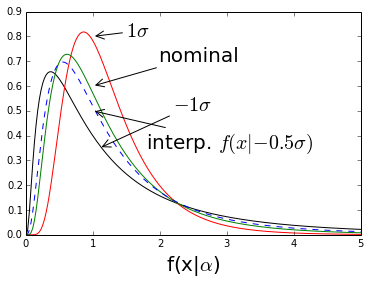

In [149]:
xarray = np.linspace(0.00001,5,200)
plt.plot(xarray,dists[0](xarray),c='black')
plt.plot(xarray,dists[1](xarray),c='r')
plt.plot(xarray,dists[2](xarray),c='g')
plt.plot(xarray,interpolant(xarray),c='b',ls='dashed')
plt.annotate('$1 \sigma$', xy=(1, 0.8), xytext=(1.5,0.8), size=20,
                         arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate('nominal', xy=(1, 0.6), xytext=(2,0.7), size=20,
                         arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate('$-1 \sigma$', xy=(1.1, 0.35), xytext=(2.2,0.5), size=20,
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate('interp. $f(x|-0.5 \sigma)$', xy=(1., 0.5), xytext=(1.8,0.35), size=20,
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.xlabel(r'f(x|$\alpha$)', fontsize = 20)

plt.show()